In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix,classification_report
import matplotlib.dates as mdates
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model,Sequential

In [4]:
mydata=pd.read_csv('D:\\Training Mongga\Programming Program\Project\MSFT.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
mydata.info()
mydata.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 2020-01-08 to 2021-01-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
 5   Volume     253 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.8 KB


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-08,158.929993,160.800003,157.949997,160.089996,158.411835,27746500
2020-01-09,161.839996,162.220001,161.029999,162.089996,160.390869,21385000
2020-01-10,162.820007,163.220001,161.179993,161.339996,159.648727,20725900
2020-01-13,161.759995,163.309998,161.259995,163.279999,161.568405,21626500
2020-01-14,163.389999,163.600006,161.720001,162.130005,160.430450,23477400


In [5]:
mydata.describe()

,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,193.829209,196.405455,191.270474,193.936324,193.018345,3.781375e+07
std,22.869121,22.370548,23.089195,22.768303,23.144477,1.681806e+07
min,137.009995,140.570007,132.520004,135.419998,134.366470,1.055060e+07
25%,175.800003,178.639999,173.800003,177.039993,175.662643,2.645800e+07
50%,202.089996,204.399994,199.619995,202.539993,201.862274,3.306480e+07
75%,213.399994,215.229996,210.839996,213.250000,212.463760,4.387230e+07
max,229.270004,232.860001,227.350006,231.649994,231.045105,9.707360e+07


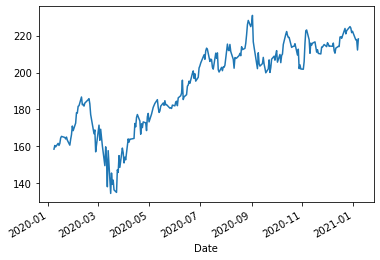

In [6]:
mydata['Adj Close'].plot()

In [7]:
X=mydata.drop(['Adj Close', 'Close'],axis=1)
X.head()

,Open,High,Low,Volume
Date,,,,
2020-01-08,158.929993,160.800003,157.949997,27746500
2020-01-09,161.839996,162.220001,161.029999,21385000
2020-01-10,162.820007,163.220001,161.179993,20725900
2020-01-13,161.759995,163.309998,161.259995,21626500
2020-01-14,163.389999,163.600006,161.720001,23477400


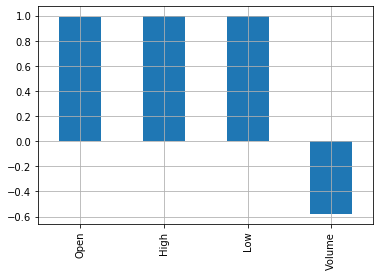

In [8]:
X.corrwith(mydata['Adj Close']).plot.bar(grid=True)

In [9]:
test=mydata
feature_columns=['Open','High','Low','Volume','Adj Close']

In [10]:
scaler=MinMaxScaler()
feature_minmax_transform_data=scaler.fit_transform(test[feature_columns])
feature_minmax_transform=pd.DataFrame(columns=feature_columns,data=feature_minmax_transform_data,index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume,Adj Close
Date,,,,,
2020-01-08,0.237589,0.219200,0.268164,0.198744,0.248714
2020-01-09,0.269131,0.234587,0.300643,0.125220,0.269185
2020-01-10,0.279753,0.245422,0.302225,0.117602,0.261508
2020-01-13,0.268264,0.246397,0.303069,0.128011,0.281364
2020-01-14,0.285931,0.249540,0.307919,0.149403,0.269594


In [11]:
target_adj_close=pd.DataFrame(feature_minmax_transform['Adj Close'])
target_adj_close=target_adj_close.shift(-1)
validation_y=target_adj_close[-90:-1]
target_adj_close=target_adj_close[:-90]

feature_minmax_transform=feature_minmax_transform.drop(['Adj Close'], axis=1)
validation_x=feature_minmax_transform[-90:-1]
feature_minmax_transform=feature_minmax_transform[:-90]

In [12]:
ts_split=TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
    X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index):]
    Y_train, Y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index):].values.ravel()

In [13]:
X_test.shape,X_train.shape

((14, 4), (149, 4))

In [14]:
dt=DecisionTreeRegressor(random_state=0)
modelawal=dt.fit(X_train,Y_train)

In [15]:
X_train=np.array(X_train)
X_test=np.array(X_test)

X_tr_t=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_ts_t=X_test.reshape(X_test.shape[0],1,X_test.shape[1])

In [16]:
K.clear_session()
model=Sequential()
model.add(LSTM(16,input_shape=(1,X_train.shape[1]), activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
early_stop=EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm=model.fit(X_tr_t,Y_train,epochs=200,verbose=1,shuffle=False,callbacks=[early_stop])

Epoch 1/200
5/5 [==============================] - 0s 12ms/step - loss: 0.2444
Epoch 2/200
5/5 [==============================] - 0s 7ms/step - loss: 0.2281
Epoch 3/200
5/5 [==============================] - 0s 7ms/step - loss: 0.2126
Epoch 4/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1978
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1835
Epoch 6/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1696
Epoch 7/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1565
Epoch 8/200
5/5 [==============================] - 0s 7ms/step - loss: 0.1440
Epoch 9/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1321
Epoch 10/200
5/5 [==============================] - 0s 6ms/step - loss: 0.1209
Epoch 11/200
5/5 [==============================] - ETA: 0s - loss: 0.060 - 0s 6ms/step - loss: 0.1104
Epoch 12/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1004
Epoch 13/200
5/5 [==================

In [17]:
y_pred_test=model.predict(X_ts_t)

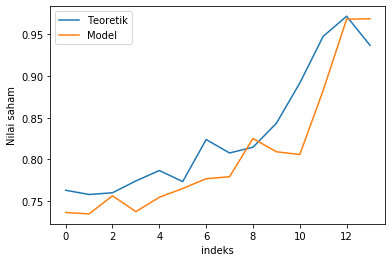

In [18]:
plt.plot(Y_test, label='Teoretik')
plt.plot(y_pred_test, label='Model')
plt.xlabel('indeks')
plt.ylabel('Nilai saham')
plt.legend()
plt.show()

In [20]:
r2_score(Y_test,y_pred_test)

0.7169771602927042